In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from insight_utils import bar_groups_chart, line_plot_column
from utils import clean_transcript, clean_summary
from constants import FORMAT_MODIFIERS, LENGTH_MODIFIERS, DENSENESS_MODIFIERS, QUALITY_MODIFIERS, STRUCTURE_MODIFIERS
import textstat
import nltk

transcript_path = "data/transcript_data.csv"
data = pd.read_csv(transcript_path)

#### Format

In [2]:
data

,title,topics,speaker,description,transcript,duration,upload_date
0,How AI could empower any business,"technology,engineering,business,entrepreneur,s...",Andrew Ng,Expensive to build and often needing highly sk...,"When I think about the rise of AI, I'm reminde...",PT11M16S,2022-09-27T14:53:08Z
1,Teachers need real feedback,"culture,global issues,education,teaching",Bill Gates,"Until recently, many teachers only got one wor...",Everyone needs a coach. It doesn't matter whet...,PT10M07S,2013-05-08T15:01:20Z
2,AI isn't as smart as you think -- but it could be,"technology,future,AI,algorithm,machine learnin...",Jeff Dean,"What is AI, really? Jeff Dean, the head of Goo...","Hi, I'm Jeff. I lead AI Research and Health at...",PT18M21S,2021-10-28T19:51:36Z
3,What if buildings created energy instead of co...,"climate change,technology,design,innovation,fu...",Ksenia Petrichenko,Buildings are bad news for the climate -- but ...,Buildings are not only what they seem. They ar...,PT13M32S,2023-02-14T15:51:33Z
4,Animal tales from icy wonderlands,"culture,design,entertainment,animals,creativit...",Paul Nicklen,Diving under the Antarctic ice to get close to...,"My journey to become a polar specialist, photo...",PT17M38S,2011-05-09T14:38:00Z
5,How online abuse of women has spiraled out of ...,"global issues,computers,gender,communication,a...",Ashley Judd,"Enough with online hate speech, sexual harassm...",[This talk contains graphic language and descr...,PT16M01S,2017-01-18T15:55:34Z
6,How whistle-blowers shape history,"politics,corruption,social change,history,soci...",Kelly Richmond Pope,Fraud researcher and documentary filmmaker Kel...,"How many of us have ever seen something, thoug...",PT11M51S,2018-10-12T14:41:22Z
7,Our dangerous obsession with perfectionism is ...,"culture,social change,psychology,depression,me...",Thomas Curran,Social psychologist Thomas Curran explores how...,"I'm a bit of a perfectionist. Now, how many ti...",PT14M45S,2019-03-14T15:02:26Z
8,Pussy Riot's powerful message to Vladimir Putin,"politics,corruption,social change,art,activism...",Nadya Tolokonnikova,"Nadya Tolokonnikova, founding member of the an...","Please, stand up. If you're able. Thank you. I...",PT13M05S,2023-04-26T15:00:06Z
9,Shape-shifting tech will change work as we kno...,"technology,design,engineering,industrial desig...",Sean Follmer,What will the world look like when we move bey...,"We've evolved with tools, and tools have evolv...",PT09M12S,2016-02-09T16:03:20Z


#### Latex tables

In [3]:
interval = 30
def break_if_long(text):
    out = ""
    for j in range(5,0,-1):
        if len(text) > j * interval:
            for i in range(j):
                out += text[i * interval : (i + 1) * interval] + "\\\\"
            return "\\makecell{" + out + "}"
    return text

def makecell(text):
    return "\\makecell{" + text + "}"

def captitalize(text):
    return text.capitalize()

# code = data.to_latex(columns=["title", "topics", "speaker"], formatters={"title": break_if_long, "topics": break_if_long, })
code = data.to_latex(columns=["title", "speaker", "topics"],)
print(code)

\begin{tabular}{llll}
\toprule
 & title & topics & speaker \\
\midrule
0 & How AI could empower any business & technology,engineering,business,entrepreneur,software,innovation,AI,data,machine learning,manufacturing & Andrew Ng \\
1 & Teachers need real feedback & culture,global issues,education,teaching & Bill Gates \\
2 & AI isn't as smart as you think -- but it could be & technology,future,AI,algorithm,machine learning,ethics & Jeff Dean \\
3 & What if buildings created energy instead of consuming it? & climate change,technology,design,innovation,future,pollution,Countdown & Ksenia Petrichenko \\
4 & Animal tales from icy wonderlands & culture,design,entertainment,animals,creativity,storytelling,photography,biodiversity,Antarctica & Paul Nicklen \\
5 & How online abuse of women has spiraled out of control & global issues,computers,gender,communication,activism,potential,women,writing,society,social media,Internet,feminism,bullying,policy,sexual violence & Ashley Judd \\
6 & How whist

### Topics

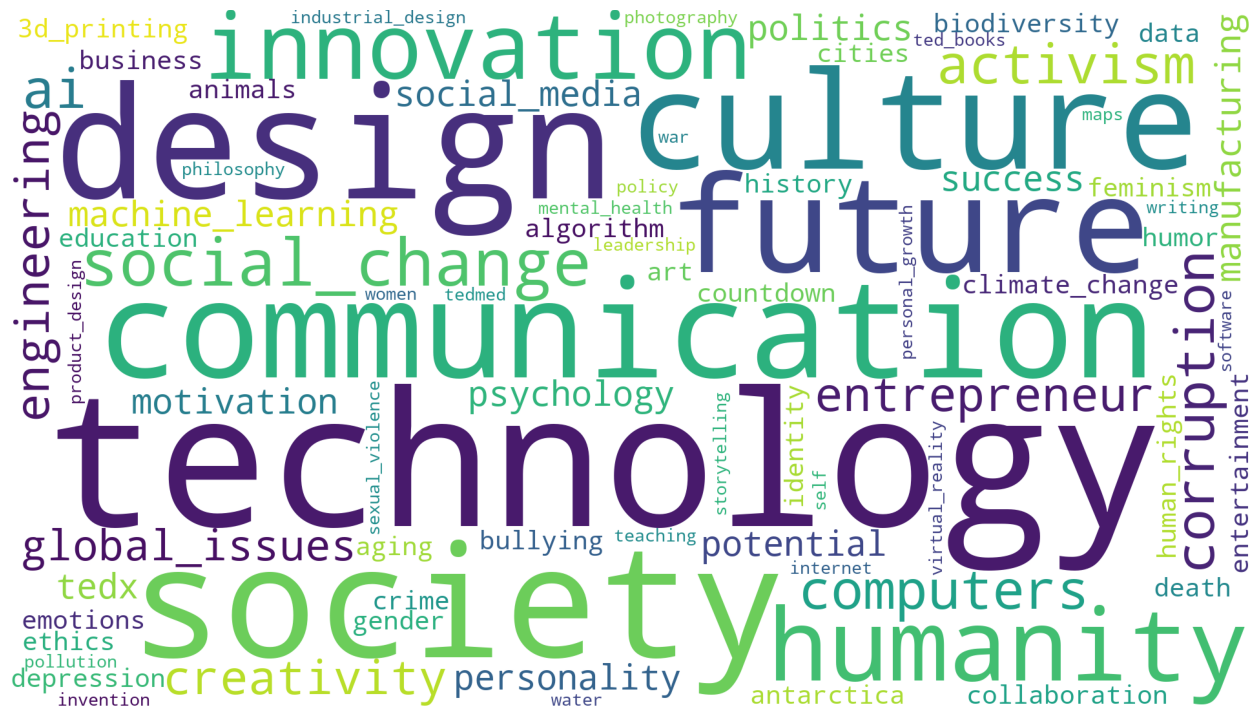

Unique topics: 78


In [4]:
import pprint


topics = data["topics"]
topics = [topic.split(",") for topic in topics]
all_topics = []
for topic_list in topics:
    for topic in topic_list:
        all_topics.append(topic.lower().strip().replace(" ", "_"))
all_topics.sort()
unique_topics = list(set(all_topics))
topic_str = ""
for topic in all_topics:
    topic_str += topic + " "

wordcloud = WordCloud(width = 1920, height = 1080,background_color ='white', collocations=False).generate(topic_str)

# plot the WordCloud image                      
plt.figure(figsize = (16, 16), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
# plt.tight_layout(pad = 0)
 
plt.savefig('data/topic_cloud.png', bbox_inches='tight')
plt.show()

print("Unique topics:", len(unique_topics))

In [12]:
transcripts = data["transcript"]

textstat.set_lang("en_US")

char_counts = []
word_counts = []
sent_counts = []
sent_lengths = []
words_in_sents = []
unique_words_count = []
all_words = []

df = pd.DataFrame(columns=["transcript","char_count", "word_count", "sent_count"])

for transcript in transcripts:
    cleaned = clean_transcript(transcript)
    
    sents = nltk.sent_tokenize(cleaned)
    sent_counts.append(len(sents))
    sent_lengths.append([len(sent) for sent in sents])
    
    words = nltk.word_tokenize(cleaned)
    word_counts.append(len(words))
    words_in_sents.append([len(nltk.word_tokenize(sent)) for sent in sents])
    
    all_words.append(words)
    unique_words_count.append(len(list(set(words))))
    
    char_counts.append(textstat.char_count(cleaned))

total_unique_words = list(set(np.concatenate(all_words)))


# get latex tabular code for mean, median, max, min, std of char, word, sent counts
df["transcript"] = transcripts
df["char_count"] = char_counts
df["word_count"] = word_counts
df["unique_words"] = unique_words_count
df["sent_count"] = sent_counts
df["title"] = data["title"]

print(df.describe().to_latex())



print(df.to_latex(columns=["title", "char_count", "word_count", "unique_words", "sent_count"], ))







\begin{tabular}{lrrrr}
\toprule
 & char_count & word_count & sent_count & unique_words \\
\midrule
count & 15.000000 & 15.000000 & 15.000000 & 15.000000 \\
mean & 8459.000000 & 2148.400000 & 113.866667 & 625.733333 \\
std & 3273.587111 & 864.591547 & 44.140792 & 160.410396 \\
min & 4128.000000 & 1069.000000 & 64.000000 & 419.000000 \\
25% & 6071.500000 & 1588.000000 & 79.000000 & 509.000000 \\
50% & 8429.000000 & 1900.000000 & 104.000000 & 583.000000 \\
75% & 9645.000000 & 2427.500000 & 140.000000 & 748.500000 \\
max & 15699.000000 & 4024.000000 & 225.000000 & 882.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrl}
\toprule
 & char_count & word_count & sent_count & unique_words & title \\
\midrule
0 & 8524 & 2089 & 84 & 583 & How AI could empower any business \\
1 & 6902 & 1773 & 104 & 546 & Teachers need real feedback \\
2 & 15699 & 3909 & 159 & 882 & AI isn't as smart as you think -- but it could be \\
3 & 8429 & 1900 & 91 & 635 & What if buildings created energy instead of 

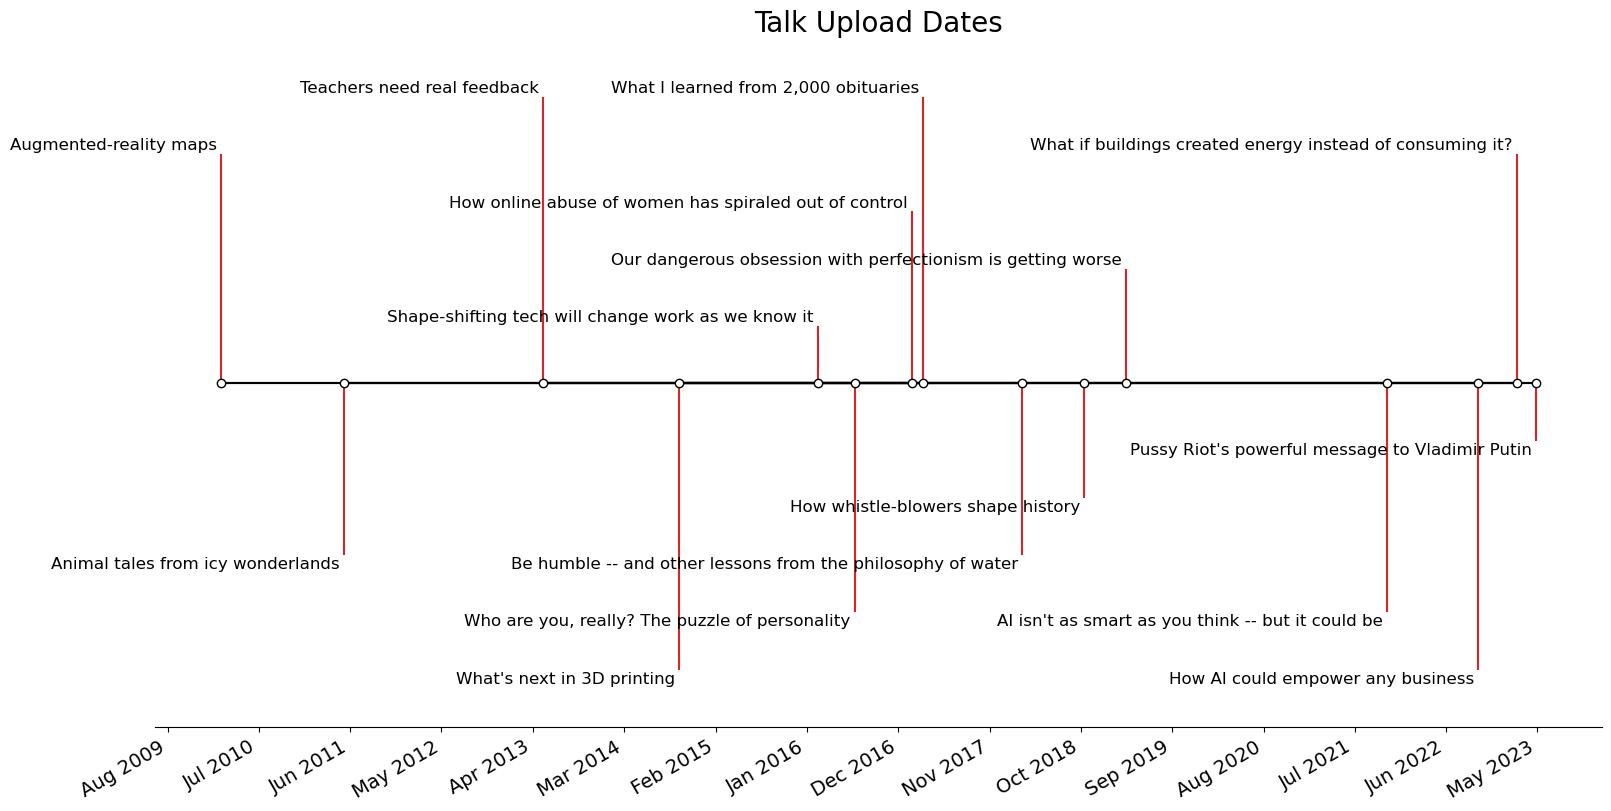

In [6]:
    # In case the above fails, e.g. because of missing internet connection
    # use the following lists as fallback.
from datetime import datetime
import matplotlib.dates as mdates



titles = data["title"]


dates = data["upload_date"]

# Convert date strings (iso utc date and time) to datetime
dates = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ") for date in dates]

# Choose some nice levels
levels = np.tile([ -5, 5, -4,4, -3, 3, -2, 2, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")
ax.set_title("Talk Upload Dates", fontsize=20)

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, t in zip(dates, levels, titles):
        ax.annotate(t, xy=(d, l), xytext=(-3, np.sign(l)*1), textcoords="offset points", horizontalalignment="right", verticalalignment="bottom" if l > 0 else "top", fontsize=12)

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=11))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=14)

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.savefig('data/talk_upload_dates.png', bbox_inches='tight')
plt.show()